In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
from functools import reduce

In [2]:

# Define the ticker symbols
tickers = {
    'BTC-USD': 'BTC',
    '^TNX': 'RF',
    'SPY': 'SPY',
    '^VIX': 'VIX'
}

# Define the date range
lookback_period = 150
start_date = pd.to_datetime('2019-11-01')
end_date = pd.to_datetime('2024-10-31')

# Initialize an empty dictionary to store DataFrames
data_frames = {}

# Loop through each ticker and download the data
for ticker, name in tickers.items():
    # Download the data
    data = yf.download(ticker, start=start_date-timedelta(days=lookback_period*2), end=end_date)
    
    # Reset index to make 'Date' a column
    data = data.reset_index()
    
    # Convert 'Date' to datetime.date format
    data['date'] = pd.to_datetime(data['Date']).dt.date
    
    # Select relevant columns and rename them
    if ticker == 'BTC-USD':
        # For Bitcoin, keep 'Close' and 'Volume'
        data = data[['date', 'Close', 'Volume']]
        data.rename(columns={'Close': 'PRC', 'Volume': 'Vol'}, inplace=True)
    elif ticker == '^TNX':
        # For 10-year Treasury Yield, keep 'Close' and adjust yield to percentage
        data = data[['date', 'Close']]
        data.rename(columns={'Close': 'RF'}, inplace=True)
        # Convert yield from percentage points to decimal (e.g., 15.00 to 0.15)
        data['RF'] = data['RF'] / 100
    else:
        # For SPY and VIX, keep 'Adj Close'
        data = data[['date', 'Adj Close']]
        data.rename(columns={'Adj Close': name}, inplace=True)
    
    # Store the DataFrame in the dictionary
    data_frames[name] = data

# Merge all DataFrames on 'date'

dfs = list(data_frames.values())
merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
merged_data.columns = merged_data.columns.get_level_values(0) 

merged_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1782/2167053777.py:50: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_1782/2167053777.py:50: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
/tmp/ipykernel_1782/2167053777.py:50: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), 

Price,date,PRC,Vol,RF,SPY,VIX
0,2019-01-07,4025.248291,5228625637,0.02682,232.238083,21.400000
1,2019-01-08,4030.847900,5306593305,0.02716,234.420044,20.469999
2,2019-01-09,4035.296387,5115905225,0.02728,235.515549,19.980000
3,2019-01-10,3678.924561,6874143796,0.02731,236.346390,19.500000
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001
...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000


In [3]:
# create the signal for the trading range breakout
merged_data['SUP'] = merged_data['PRC'].shift(1).rolling(window=lookback_period).min()
merged_data['RES'] = merged_data['PRC'].shift(1).rolling(window=lookback_period).max()
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES
0,2019-01-07,4025.248291,5228625637,0.02682,232.238083,21.400000,NaN,NaN
1,2019-01-08,4030.847900,5306593305,0.02716,234.420044,20.469999,NaN,NaN
2,2019-01-09,4035.296387,5115905225,0.02728,235.515549,19.980000,NaN,NaN
3,2019-01-10,3678.924561,6874143796,0.02731,236.346390,19.500000,NaN,NaN
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001,NaN,NaN
...,...,...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375


In [5]:
merged_data['EMA_12'] = merged_data['PRC'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['PRC'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']
merged_data['MACD_Sig'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()
merged_data['MACD_Hist'] = merged_data['MACD'] - merged_data['MACD_Sig']
merged_data

Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist
0,2019-01-07,4025.248291,5228625637,0.02682,232.238083,21.400000,NaN,NaN,4025.248291,4025.248291,0.000000,0.000000,0.000000
1,2019-01-08,4030.847900,5306593305,0.02716,234.420044,20.469999,NaN,NaN,4026.109769,4025.663077,0.446692,0.089338,0.357354
2,2019-01-09,4035.296387,5115905225,0.02728,235.515549,19.980000,NaN,NaN,4027.523095,4026.376655,1.146440,0.300759,0.845681
3,2019-01-10,3678.924561,6874143796,0.02731,236.346390,19.500000,NaN,NaN,3973.892551,4000.639463,-26.746912,-5.108775,-21.638136
4,2019-01-11,3687.365479,5538712865,0.02701,236.437653,18.190001,NaN,NaN,3929.811463,3977.433983,-47.622520,-13.611524,-34.010995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345
1461,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718
1462,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691
1463,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909


In [6]:
merged_data = merged_data.dropna()
merged_data = merged_data[(merged_data['date'] >= pd.to_datetime(start_date).date()) & (merged_data['date'] <= pd.to_datetime(end_date).date())]
merged_data = merged_data.reset_index(drop=True)

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,4158.183105,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813
1,2019-11-04,9412.612305,26170255634,0.01786,284.530396,12.830000,4879.877930,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505
2,2019-11-05,9342.527344,26198609048,0.01866,284.215698,13.100000,4922.798828,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,4922.798828,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821
4,2019-11-07,9267.561523,22700383839,0.01926,285.280304,12.730000,5036.681152,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909


In [30]:
merged_data['sig_1'] = np.where(merged_data['PRC'] > merged_data['RES'], 1, 0)  # Buy signal
merged_data['sig_1'] = np.where(merged_data['PRC'] < merged_data['SUP'], -1, merged_data['sig_1'])  # Sell signal

merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] > 0) & (merged_data['MACD_Hist'].shift() < 0), 1, 0)  # Buy signal
merged_data['sig_2'] = np.where((merged_data['MACD_Hist'] < 0) & (merged_data['MACD_Hist'].shift() > 0), -1, merged_data['sig_2'])  # Sell signal

merged_data

Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,cumulative_return,sig_3
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,4158.183105,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813,0,0,1.000000,0
1,2019-11-04,9412.612305,26170255634,0.01786,284.530396,12.830000,4879.877930,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505,0,0,1.000000,0
2,2019-11-05,9342.527344,26198609048,0.01866,284.215698,13.100000,4922.798828,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847,0,0,1.000000,0
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,4922.798828,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821,0,0,1.000000,0
4,2019-11-07,9267.561523,22700383839,0.01926,285.280304,12.730000,5036.681152,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922,0,0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,8.850465,0
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,8.653275,0
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,9.077268,0
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,9.442491,1


In [31]:
def test_fcn(data, cb, cs, sig_name):
    T = len(data)
    nUSD = 1.0
    nBTC = 0.0
    CR = [1.0]

    # Trading simulation loop
    for t in range(T - 1):
        # Get the signal for the current time step
        signal = data.loc[t, sig_name]
        price_t = data.loc[t, 'PRC']
        price_t1 = data.loc[t + 1, 'PRC']
    
        if signal == 1 and nBTC == 0:  # Buy condition
            nBTC = nUSD * (1 - cb) / price_t
            nUSD = 0
        elif signal == -1 and nBTC > 0:  # Sell condition
            nUSD = nBTC * (1 - cs) * price_t
            nBTC = 0
        # elif signal == -1 and nBTC == 0:  # Short condition
        # nBTCb = nUSD / price_t
        # nUSD = nUSD + nBTCb * (1 - cs) * price_t - nBTCb * price_t1 / (1 - cb)
    
        # Update cumulative return
        CR.append(nUSD + nBTC * price_t1 * (1 - cs))

    # Save cumulative return to the data frame
    data['cumulative_return'] = CR

    return data

In [40]:
# testing

test_fcn(merged_data, 0.001, 0.001, 'sig_1')


Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,cumulative_return,sig_3
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,4158.183105,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813,0,0,1.000000,0
1,2019-11-04,9412.612305,26170255634,0.01786,284.530396,12.830000,4879.877930,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505,0,0,1.000000,0
2,2019-11-05,9342.527344,26198609048,0.01866,284.215698,13.100000,4922.798828,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847,0,0,1.000000,0
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,4922.798828,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821,0,0,1.000000,0
4,2019-11-07,9267.561523,22700383839,0.01926,285.280304,12.730000,5036.681152,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922,0,0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,9.062219,0
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,8.860311,0
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,9.294448,0
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,9.668410,1


In [41]:
test_fcn(merged_data, 0.001, 0.001, 'sig_2')

Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,cumulative_return,sig_3
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,4158.183105,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813,0,0,1.000000,0
1,2019-11-04,9412.612305,26170255634,0.01786,284.530396,12.830000,4879.877930,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505,0,0,1.000000,0
2,2019-11-05,9342.527344,26198609048,0.01866,284.215698,13.100000,4922.798828,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847,0,0,1.000000,0
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,4922.798828,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821,0,0,1.000000,0
4,2019-11-07,9267.561523,22700383839,0.01926,285.280304,12.730000,5036.681152,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922,0,0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,5.932924,0
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,5.800738,0
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,6.084962,0
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,6.329790,1


<Axes: >

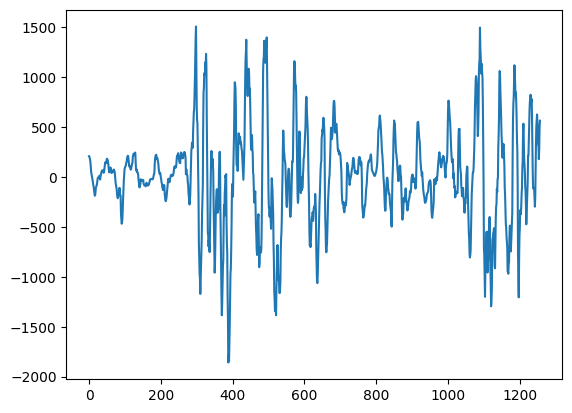

In [39]:
merged_data['MACD_Hist'].plot()

In [42]:
def calculate_sig3(row):
    if row['sig_1'] == 1 or row['sig_2'] == 1:
        return 1
    elif row['sig_1'] == -1 or row['sig_2'] == -1:
        return -1
    else:
        return 0

merged_data['sig_3'] = merged_data.apply(calculate_sig3, axis=1)

test_fcn(merged_data, 0.001, 0.001, 'sig_3')


Price,date,PRC,Vol,RF,SPY,VIX,SUP,RES,EMA_12,EMA_26,MACD,MACD_Sig,MACD_Hist,sig_1,sig_2,cumulative_return,sig_3
0,2019-11-01,9261.104492,24324691031,0.01728,283.391846,12.300000,4158.183105,13016.231445,8775.290615,8743.600599,31.690016,-175.913797,207.603813,0,0,1.000000,0
1,2019-11-04,9412.612305,26170255634,0.01786,284.530396,12.830000,4879.877930,13016.231445,8873.340105,8793.157021,80.183084,-124.694421,204.877505,0,0,1.000000,0
2,2019-11-05,9342.527344,26198609048,0.01866,284.215698,13.100000,4922.798828,13016.231445,8945.522758,8833.851119,111.671638,-77.421209,189.092847,0,0,1.000000,0
3,2019-11-06,9360.879883,23133895765,0.01814,284.280487,12.620000,4922.798828,13016.231445,9009.423854,8872.890287,136.533567,-34.630254,171.163821,0,0,1.000000,0
4,2019-11-07,9267.561523,22700383839,0.01926,285.280304,12.730000,5036.681152,13016.231445,9049.137341,8902.125193,147.012148,1.698226,145.313922,0,0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-10-24,68161.054688,31414428647,0.04200,579.239990,19.080000,53948.753906,71631.359375,66139.387225,64391.208851,1748.178373,1436.399029,311.779345,0,0,7.279215,0
1253,2024-10-25,66642.414062,41469984306,0.04232,579.039978,20.330000,53948.753906,71631.359375,66216.775969,64557.964793,1658.811176,1480.881458,177.929718,0,0,7.117033,0
1254,2024-10-28,69907.757812,38799856657,0.04278,580.830017,19.799999,53948.753906,71631.359375,66784.619329,64954.245757,1830.373572,1550.779881,279.593691,0,0,7.465753,0
1255,2024-10-29,72720.492188,58541874402,0.04274,581.770020,19.340000,53948.753906,71631.359375,67697.830538,65529.523271,2168.307268,1674.285358,494.021909,1,0,7.766137,1


In [9]:
(data['SPY'].iloc[-1] / data['SPY'].iloc[0]) - 1

np.float64(1.0466710444955551)

In [10]:
# Calculate excess returns
data['excess_return'] = data['cumulative_return'] - data['RF'] / 252

# Calculate mean and standard deviation of excess returns
mean_excess_return = data['excess_return'].mean()
std_excess_return = data['excess_return'].std()

# Calculate Sharpe Ratio
sharpe_ratio = mean_excess_return / std_excess_return

In [ ]:
from pytrends.request import TrendReq
import pandas as pd

# Step 1: Connect to Google Trends
pytrends = TrendReq(hl='en-US', tz=360)  # Set language and timezone

# Step 2: Define the keyword and time period
keyword = ['bitcoin']  # Keyword(s) to search
timeframe = '2015-01-01 2024-11-22'  # Set the time range

# Step 3: Build payload
pytrends.build_payload(keyword, cat=0, timeframe=timeframe, geo='', gprop='')

# Step 4: Get interest over time
trends_data = pytrends.interest_over_time()

# Step 5: Clean up the data
if 'isPartial' in trends_data.columns:
    trends_data = trends_data.drop(columns=['isPartial'])  # Drop 'isPartial' if it exists

# Reset index to make 'date' a column
trends_data = trends_data.reset_index()

# Display the first few rows
trends_data


/home/codespace/.python/current/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,date,bitcoin
0,2015-01-01,3
1,2015-02-01,3
2,2015-03-01,3
3,2015-04-01,2
4,2015-05-01,2
...,...,...
114,2024-07-01,21
115,2024-08-01,23
116,2024-09-01,17
117,2024-10-01,18


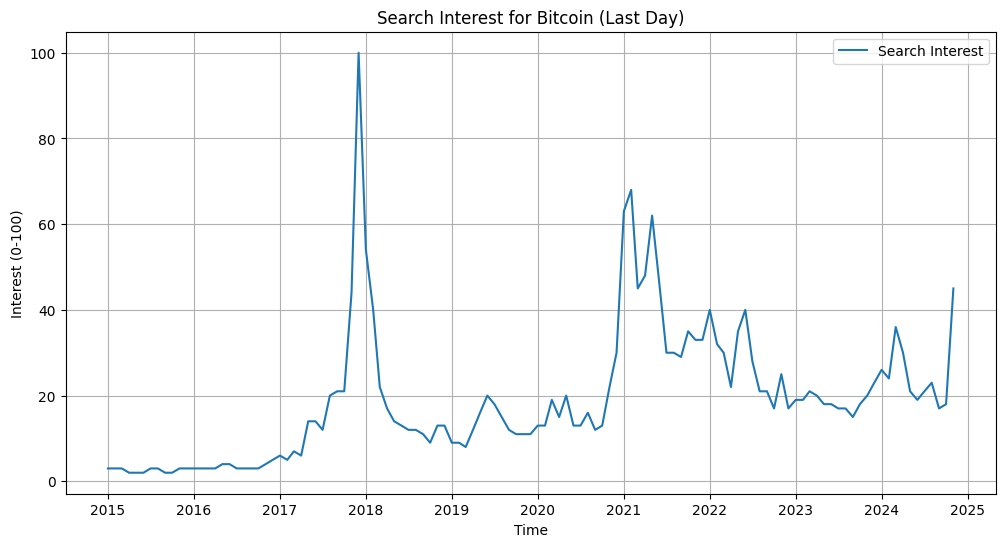

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(trends_data['date'], trends_data['bitcoin'], label='Search Interest')
plt.title('Search Interest for Bitcoin (Last Day)')
plt.xlabel('Time')
plt.ylabel('Interest (0-100)')
plt.legend()
plt.grid()
plt.show()